# Bericht
## Projektlabor Maschinelles Lernen (PML)

**Gruppe 7**
* Christian Singer
* Domenic Gosein
* Lukas Burger
* Maximilian Kürschner

Dozent: Dr.-Ing. Wei Yap Tan  
Fakultät der Informationstechnik  
Hochschule Mannheim  
WiSe 2021/22  

### Einleitung

tbd

### Data Generator 3D

tbd

In [3]:
'''
This script simulates a 3D-Radar-Sensor capable of outputing 
detected position and velocity and amplitude of an object.

The simulation is done at 100 times the measurement rate of the sensor,
then decimate it to the actual measurement rate
'''

'''
Sensor characteristics
'''

import numpy
minRange = 0.3  # m
maxRange = 25.0  # m
maxVelocity = 25  # m/s --> 90 km/h

rangeAccuracy = 0.05  # m
velocityAccuracy = 0.005  # m/s
measurementRate = 30  # Hz

sensorPosition = numpy.array([0,0,0.8]) # x,y,z-coordinate of the sensor

'''
Class definition of a target
'''

class Target:
    def __init__(self, opt):
        self.ValidateOption(opt)
        self.currentPosition = self.opt['InitialPosition']
        self.Trajectory = [self.opt['InitialPosition']]
        self.velocityVector = numpy.zeros((3,))
        self.pathCounter = 0  
        self.reachedEnd = False      

    def ValidateOption(self, opt):
        if(('InitialPosition' in opt) == False):
            raise Exception("Missing value for 'InitialPosition'")
        else:
            if(type(opt['InitialPosition']) is not numpy.ndarray):
                raise Exception("InitialPosition should be a numpy.ndarray with the shape (3,).")
            else:
                if(numpy.shape(opt['InitialPosition']) != (3,)):
                    raise Exception("InitialPosition should be a numpy.ndarray with the shape (3,).")

        if(('Path' in opt) == False):
            raise Exception("Missing value for 'Path'")
        else:
            if(type(opt['Path']) is not numpy.ndarray):
                raise Exception("Path should be a numpy.ndarray with the shape (3,n).")
            else:
                if(numpy.size(opt['Path'],0) != 3):
                    raise Exception("Path should be a numpy.ndarray with the shape (3,n).")

        if(('Velocities' in opt) == False):
            raise Exception("Missing value for 'Velocities'")
        else:
            if(type(opt['Velocities']) is not numpy.ndarray):
                raise Exception("Velocities should be a numpy.ndarray with the shape (1,n).")
            else:
                if(numpy.size(opt['Velocities'],0) != 1):
                    raise Exception("Velocities should be a numpy.ndarray with the shape (1,n).")

                if(numpy.size(opt['Velocities'],1) != numpy.size(opt['Path'],1)):
                    raise Exception("Velocities and Path should have the same length.")

        self.opt = opt

    def Step(self, deltaTime):
        # check if we are at the end
        if(self.pathCounter > numpy.size(self.opt['Path'],1) - 1):
            self.reachedEnd = True
            return self.currentPosition, self.velocityVector
                
        velocityVector = self.__GetVelocityVector(self.currentPosition, self.opt['Path'][:, self.pathCounter], self.opt['Velocities'][0, self.pathCounter])

        # try to step
        nextPosition = self.currentPosition + velocityVector * deltaTime

        # now check if we are within the next path target
        if(numpy.linalg.norm(nextPosition - self.currentPosition) < numpy.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)):
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            self.velocityVector = velocityVector
            return self.currentPosition, self.velocityVector

        else: # we have to microstep
            # get the time to current path target
            countDown = deltaTime
            stepFurther = True
            while(stepFurther == True):
                microtime = (numpy.linalg.norm(self.opt['Path'][:, self.pathCounter] - self.currentPosition)/numpy.linalg.norm(nextPosition - self.currentPosition)) * countDown
                resttime = countDown - microtime

                if(self.pathCounter + 1 == numpy.size(self.opt['Path'],1)):
                    stepFurther == False
                    self.pathCounter = self.pathCounter + 1
                    self.velocityVector = numpy.zeros((3,))
                    self.currentPosition = self.opt['Path'][:, self.pathCounter - 1]
                    self.reachedEnd = True
                    return self.currentPosition, self.velocityVector

                velocityVector = self.__GetVelocityVector(self.opt['Path'][:, self.pathCounter], self.opt['Path'][:, self.pathCounter + 1], self.opt['Velocities'][:, self.pathCounter + 1])
                # try to step
                nextPosition = self.opt['Path'][:, self.pathCounter] + velocityVector * resttime

                if(numpy.linalg.norm(nextPosition - self.opt['Path'][:, self.pathCounter]) < numpy.linalg.norm(self.opt['Path'][:, self.pathCounter + 1] - self.opt['Path'][:, self.pathCounter])):
                    stepFurther = False 

                # we proceed to next path target
                self.pathCounter = self.pathCounter + 1

            self.velocityVector = velocityVector
            self.currentPosition = nextPosition
            self.Trajectory.append(nextPosition)
            return self.currentPosition, self.velocityVector

    def __GetVelocityVector(self, Position1, Position2, Velocity):
        targetPosition = Position2
        movementDirection = targetPosition - Position1
        movementDirection = movementDirection / numpy.linalg.norm(movementDirection)

        return Velocity * movementDirection
    
class RadarSensor:
    def __init__(self, opt):
        self.ValidateOption(opt)
        opt['MinRange'] = minRange
        opt['MaxRange'] = maxRange
        opt['MaxVelocity'] = maxVelocity
        opt['RangeAccuracy'] = rangeAccuracy
        opt['VelocityAccuracy'] = velocityAccuracy
        opt['MeasurementRate'] = 30

    def ValidateOption(self, opt):
        if(('Position' in opt) == False):
            raise Exception("Missing value for 'Position'")
        else:
            if(type(opt['Position']) is not numpy.ndarray):
                raise Exception("Position should be a numpy.ndarray with the shape (3,).")
            else:
                if(numpy.shape(opt['Position']) != (3,)):
                    raise Exception("Position should be a numpy.ndarray with the shape (3,).")

        if(('OpeningAngle' in opt) == False):
            raise Exception("Missing value for 'OpeningAngle'")
        else:
            if(type(opt['OpeningAngle']) is not numpy.ndarray):
                raise Exception("OpeningAngle should be a numpy.ndarray with the shape (2,).")
            else:
                if(numpy.size(opt['OpeningAngle'],0) != 2):
                    raise Exception("OpeningAngle should be a numpy.ndarray with the shape (2,).")

        self.opt = opt

    def Detect(self, targets):
        if len(targets) == 0:
            return None

        # initiate list
        detections = []

        # looping through targets
        for target in targets:
            visibleHor = False
            visibleVer = False
            
            # check horizontal angle
            horAngle = numpy.rad2deg(numpy.arctan((target.currentPosition[0] - self.opt['Position'][0])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(numpy.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                visibleHor = True

            # check vertical angle
            verAngle = numpy.rad2deg(numpy.arctan((target.currentPosition[2] - self.opt['Position'][2])/(target.currentPosition[1] - self.opt['Position'][1])))
            if(numpy.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                visibleVer = True

            # if target visible
            if(visibleVer == True and visibleHor == True):            
                currPos = target.currentPosition - self.opt['Position']

                if(numpy.linalg.norm(currPos) > self.opt['MinRange'] and numpy.linalg.norm(currPos) < self.opt['MaxRange']):
                    bVector = self.opt['Position'] - target.currentPosition
                    radialVelocityToSensor = (numpy.dot(target.velocityVector, bVector)/numpy.dot(bVector, bVector)) + numpy.random.uniform(-1*self.opt['VelocityAccuracy'],self.opt['VelocityAccuracy'],1)
                    currPos = currPos + numpy.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                    currPos = numpy.append(currPos, radialVelocityToSensor)

                    if(radialVelocityToSensor < self.opt['MaxVelocity']):
                        detections.append(currPos)


        # add noise / false detection ?
        if(('FalseDetection' in self.opt) == True):
            if(self.opt['FalseDetection'] == True):
                for i in range(20):
                    randPos = numpy.random.uniform(self.opt['MinRange'], 2 * self.opt['MaxRange'], 3)
                    randVel = numpy.random.uniform(0, 2 * self.opt['MaxVelocity'], 1)
                    visibleHor = False
                    visibleVer = False
                    
                    # check horizontal angle
                    horAngle = numpy.rad2deg(numpy.arctan((randPos[0] - self.opt['Position'][0])/(randPos[1] - self.opt['Position'][1])))
                    if(numpy.abs(horAngle) < self.opt['OpeningAngle'][0]/2.0):
                        visibleHor = True

                    # check vertical angle
                    verAngle = numpy.rad2deg(numpy.arctan((randPos[2] - self.opt['Position'][2])/(randPos[1] - self.opt['Position'][1])))
                    if(numpy.abs(verAngle) < self.opt['OpeningAngle'][1]/2.0):
                        visibleVer = True

                    # if target visible
                    if(visibleVer == True and visibleHor == True):            
                        randPos = randPos - self.opt['Position']

                        if(numpy.linalg.norm(randPos) > self.opt['MinRange'] and numpy.linalg.norm(randPos) < self.opt['MaxRange']):
                            bVector = self.opt['Position'] - randPos
                            randPos = randPos + numpy.random.uniform(-1*self.opt['RangeAccuracy'],self.opt['RangeAccuracy'],3)
                            randPos = numpy.append(randPos, randVel)
                            if(randVel < self.opt['MaxVelocity']):
                                detections.append(randPos)

        return detections


### Kalman Filter

tbd

In [4]:
import numpy as np

model_move = lambda est, dt: np.array([est[0] + est[1]*dt, 1])

class abFilter():
    def __init__(self, a, model):
        self.a = a
        self.epoch = 0
        self.estimate = None
        # Process model
        self.model = model
        
    def step(self, s, dt):
        
        if self.estimate is None:
            self.estimate = s
            return s
        
        else:
            # Predict
            s_pred = self.model(self.estimate,dt)
            
            # Update
            residual = s - s_pred
            self.estimate = self.estimate + self.a * residual
            return self.estimate

class KalmanFilter:
    # Initialisierung von Kalman Filter
    def __init__(self, s_hat, transition_model, H, Q, R):
        self.s_hat = s_hat
        self.P_hat = np.eye(len(s_hat)) * 100
        self.model = transition_model
        self.H = H # Measurement Function
        self.Q = Q # Process Noise
        self.R = R # Measurement Noise.
        pass

    def step(self,z):
        # Prediction
        s_hat_p = self.model @ self.s_hat
        P_hat_p = self.model @ self.P_hat @ self.model.T +  self.Q
        # Calculate Kalman Matrix
        K = P_hat_p @ self.H.T @ np.linalg.inv(self.H @ P_hat_p @ self.H.T + self.R)
        # Update covariance of estimation error
        self.P_hat = self.P_hat - K @ self.H @ self.P_hat
        # Improve estimate
        e_m_p = z - self.H @ s_hat_p
        self.s_hat = s_hat_p + K @ e_m_p
        
        return self.s_hat

if __name__ == "__main__":
    
    # Measurement Error
    ## Variance of a uniform distribution is given by (b-a)**2/12.
    R = np.diag([1**2, 1**2])/3
    # todo: Add variance.
    Q = np.diag([0.05,0.05,0.05])
    # todo: add column for acceleration
    s0 = np.array([[1,1],
                   [2,2],
                   [3,3]])
    #todo: Add acceleration.
    transition_model = np.array([[1, 0.01, 0.01/2],
                                 [0, 1, 0.01],
                                 [0, 0, 0.01]])
    # todo: adjust H for accomodating acceleration.
    H =  np.array([[1., 0., 0.],
                   [0., 1., 0.]])
    kf = KalmanFilter(s0, transition_model, H, Q, R)

### DBScan

tbd

In [5]:
import numpy as np

# deque provides an O(1) time complexity for append and pop operations instead of O(n) for lists.
from collections import deque
# dataset to toy around with.
from sklearn.datasets import make_moons

def pairwise_sq_distance(X1, X2):
    # Calculate the pairwise distance between all pairs of points from X1 and X2.
    return np.sum(X1**2, axis=1, keepdims=True) - 2*np.matmul(X1, X2.T) + np.sum(X2**2, axis=1, keepdims=True).T

class DBSCAN():
    
    def __init__(self, eps=0.5, minpts=5):
        self.eps = eps
        self.minpts = minpts
        
    def fit(self, X):
        dist = pairwise_sq_distance(X, X)
        neighbours = list(map(lambda d: np.arange(d.shape[0])[d < self.eps**2], dist))
        
        # Label all points as outliers initially.
        self.assignment = np.full((X.shape[0],), -1, dtype=np.int)
        # Find core points.
        ## Determine the number of neighbors of each point.
        N_neighbors = np.sum(dist < self.eps**2, axis=1)
        self.assignment[N_neighbors >= self.minpts] = -2
        
        # Create clusters.
        cluster = 0
        stack = deque()
        for p in range(X.shape[0]):
            if self.assignment[p] != -2:
                continue
                
            self.assignment[p] = cluster
            
            stack.extend(neighbours[p])
            # Expand cluster outwards. 
            while len(stack) > 0:
                n = stack.pop()
                label = self.assignment[n]
                # If core point include all points in ε-neighborhood.
                if label == -2:
                    stack.extend(neighbours[n])
                # If not core point (edge of cluster).
                if label < 0:
                    self.assignment[n] = cluster
            
            cluster += 1
            
    def fit_predict(self, X):
        self.fit(X)
        return self.assignment
    
    def predict(self,X):
        return self.assignment
    
if __name__ == '__main__':
    X,y = make_moons(100)
    model = DBSCAN()
    preds = model.fit_predict(X)
    # Either low or high values are good since DBSCAN might switch class labels.
    print(f"Accuracy: {round((sum(preds == y)/len(preds))*100,2)}%")

Accuracy: 0.0%


/tmp/ipykernel_8919/4074281381.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.assignment = np.full((X.shape[0],), -1, dtype=np.int)


### Experiment

tbd

/tmp/ipykernel_8919/4074281381.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.assignment = np.full((X.shape[0],), -1, dtype=np.int)


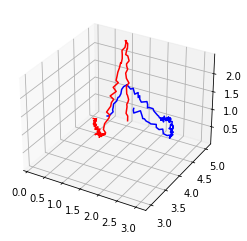

In [6]:
#from DataGenerationRadar3D import RadarSensor, Target, rangeAccuracy

#from RadarSensor3D import *

import numpy as np
#from DBScan import DBSCAN
#from KalmanFilter import KalmanFilter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



'''
Example for creating a target and design its path
'''

# Parameters first target.
path1 = [[0,5,0],
         [0,5,0.5],
         [1,4,1],
         [2,3,2],
         [1,5,3],
         [1,5,0.5],
         [0.5, 2, 0.1]]

vel1 = 3 * np.ones((1,len(path1)))
vel1[0,2] = 1

InitialPosition1 = np.array([-1,5,0])

opt1 = {
    'InitialPosition' : InitialPosition1,
    'Path' : np.array(path1).transpose(),
    'Velocities' : vel1
}


# Parameters second target.
path2 = [[1. , 4. , 1. ],
         [1. , 5. , 1.7],
         [2. , 5. , 1. ],
         [3. , 4. , 2. ],
         [3. , 4. , 1.5],
         [2. , 4. , 2. ]]

vel2 = 2 * np.ones((1,len(path2)))
vel2[0,4] = 0.5

InitialPosition2 = np.array([2,4,1])

opt2 = {
    'InitialPosition' : InitialPosition2,
    'Path' : np.array(path2).transpose(),
    'Velocities' : vel2
}


# Instantiate targets
x = Target(opt1)
y = Target(opt2)


targets = [x, y]

'''
Setup the radar sensor
The radar sensor points always to the direction along the y axis
(see diagram in the note)
'''

optRadar = {
    'Position' : np.array([0,0,0.5]),
    'OpeningAngle' : np.array([120,90]), # [Horizontal, Vertical]
    'FalseDetection': True
}
sensor = RadarSensor(optRadar)

# Measurement error.
## Variance of a uniform distribution is given by (b-a)**2/12.
R = np.diag([rangeAccuracy**2])/3
# Process error.
Q = np.diag([0.05,0.05,0.05])
# Process/transition model.
transition_model = np.array([[1, 0.01, 0.01/2],
                             [0, 1, 0.01],
                             [0, 0, 0.01]])
# Transformation matrix
## Transforms predicted quantities into outputs that can be compared to the measurements
H =  np.array([[1., 0., 0.]])


getNext = True
Detections = np.array([0,0,0])
model = DBSCAN(eps=0.2, minpts=2)
# Number of previous measurements to consider for DBSCAN().
ante = 20
# Count number of iterations
i = 0

while(getNext == True):
    i += 1
    for target in targets:
        target.Step(1/sensor.opt['MeasurementRate'])
        getNext = getNext & ~target.reachedEnd  

    dets = sensor.Detect(targets)
    # Exclude radialVelocity for the moment. (todo: include it.)
    for det in dets:
        det = det[:-1]
        Detections = np.vstack((det, Detections))
    
    # Execute once to initialize filters etc. todo: Is there a smarter way to do all below ?
    if i == ante:
        # First application of DBSCAN.
        clusters = model.fit_predict(Detections[:ante])
        # Determine number of targets (objects tracked).
        num_objs = len(set(clusters[clusters > -1]))
        
        # "Filters" contains a kalman filter for each target.
        Filters = []
        # "Preds" contains the predictions of the path of each target.
        Preds = []
        # Iterate over the targets.
        for j in range(num_objs):
            # Find index of first occurence of target j in clusters. This line is needed to filter out false detections
            obj_idx = np.where(clusters == j)[0][0]
            # Add placeholder values for speed and acceleration in each component to the detection.
            s0 = np.vstack((Detections[obj_idx], np.zeros((2,3))))
            Filters.append(KalmanFilter(s0, transition_model, H, Q, R))
            # For the moment only the predicted position is relevant. todo: incorporate velocity.
            Preds.append(s0[0,:])

    # Cluster and predict position via Kalman filter.
    elif i > ante:
        clusters = model.fit_predict(Detections[:ante])
        for j in range(num_objs):
            # try/ except prevents non-detection of existing object from breaking the program.
            try:
                obj_idx = np.where(clusters == j)[0][0]
                # Reshape is needed to make matrix multiplication inside the kalman filter work.
                s = Detections[obj_idx].reshape(1,3)
                s_hat = Filters[j].step(s)
                Preds[j] = np.vstack((s_hat[0,:], Preds[j]))
            except IndexError:
                print(f"Object {j} not found!")
                continue
         
            

if __name__ == "__main__":
    # Visualize trajectory.
    T1 = Preds[0][:-1]
    T2 = Preds[1][:-1]
    
    # Plot Trajectory
    fig = plt.figure()
    ax = plt.axes(projection='3d')   
    #ax.view_init(20, 35) 
    ax.plot3D(T1[:,0], T1[:,1], T1[:,2], 'blue')   
    ax.plot3D(T2[:,0], T2[:,1], T2[:,2], 'red')    
    
    # show plot
    plt.show()

    # Other previous visualization experiments.
    # model = DBSCAN(eps=0.2, minpts=7)        
    # T = np.vstack((T1,T2))
    # clusters = model.fit_predict(T)    
    # fig = plt.figure()
    # ax = plt.axes(projection ="3d")  
    # ax.scatter(T[:,0], T[:,1], T[:,2], c = clusters)
    
    
    # fig2 = plt.figure()
    # ax2 = plt.axes(projection='3d')   
    # #ax.view_init(20, 35) 
    # ax2.plot3D(Detections[:,0], Detections[:,1], Detections[:,2], 'blue')       
    
    # ax2.set_xlim3d(0, 5)
    # ax2.set_ylim3d(0, 5)
    # ax2.set_zlim3d(0, 5)
    
    # model = DBSCAN(eps=0.2, minpts=3)  
    # ante = -10   
    # clusters = model.fit_predict(Detections[:ante])    
    # fig = plt.figure()
    # ax3 = plt.axes(projection ="3d") 
    
    # ax3.set_xlim3d(0, 5)
    # ax3.set_ylim3d(0, 5)
    # ax3.set_zlim3d(0, 5)
    
    # ax3.scatter(Detections[:ante,0], Detections[:ante,1], Detections[:ante,2], c = clusters)